\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

In [1]:
# contents of problem1.py

import numpy as np

def get_data(n):
#     np.random.seed(0)               # fix seed
    x = np.random.uniform(size=n)
    y = x**2-x/2.0 + np.random.normal(size=n,scale=0.1)
    idx = np.argsort(x)
    return(x[idx].reshape((-1,1)),y[idx].reshape((-1,1)))

def true_mean(x):
    return(x**2-x/2.0)


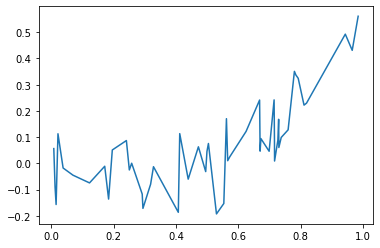

In [2]:
import matplotlib.pyplot as plt

X_train, y_train = get_data(50)
plt.plot(X_train, y_train)
plt.show()

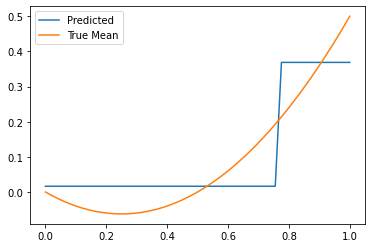

In [3]:
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame

tree = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
df = DataFrame({'Predicted': tree.predict(xgrid), 'True Mean': true_mean(xgrid).flatten()}, index=xgrid.flatten())
df.plot()
plt.show()

## (b) {-}

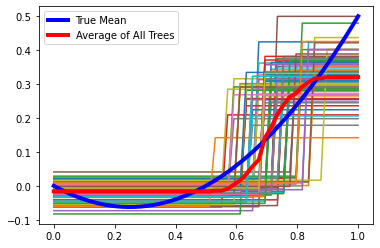

In [16]:
xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)

pred = []
for i in range(100):
    X_train, y_train = get_data(50)
    tree = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
    pred_this_run = tree.predict(xgrid)
    pred.append(pred_this_run)
    plt.plot(xgrid, pred_this_run, label=None)

true = true_mean(xgrid).flatten()
pred_mean = np.array(pred).mean(axis=0)
plt.plot(xgrid, true, 'b', linewidth=4, label='True Mean')
plt.plot(xgrid, pred_mean, 'r', linewidth=4, label='Average of All Trees')
plt.legend()
plt.show()